# Numerai Example Notebook

Welcome to the [Numerai](https://numer.ai/) data science tournament! If you are just getting started, this notebook is for you.

In this notebook we will go through
1. Dataset: how to download it and its basic structure
2. Modelling: how to train our first model and evaluate its performance  
3. Submissions: how to upload our first model to start competing in the tournament

In [93]:
# Install dependencies
%pip install -q numerapi pandas matplotlib lightgbm pyarrow cloudpickle

Note: you may need to restart the kernel to use updated packages.


## 1. Dataset  

Let's download the dataset and get familar with its basic structure. 


In [56]:
# Numerai API is the official Python API client for Numerai
from numerapi import NumerAPI
import pandas as pd
import numpy as np
import json

In [4]:
# v4.1 is the latest version of the dataset
# Let's download the training data and feature metadata files
# This will take about 1 minute 🍵
napi = NumerAPI()
napi.download_dataset("v4.1/train.parquet")
napi.download_dataset("v4.1/features.json")

2023-04-06 21:17:50,011 INFO numerapi.utils: target file already exists
2023-04-06 21:17:50,012 INFO numerapi.utils: download complete
2023-04-06 21:17:50,600 INFO numerapi.utils: target file already exists
2023-04-06 21:17:50,601 INFO numerapi.utils: download complete


In [20]:
# The feature metadata file contains a lot of useful information about the features
# In particular, it defines a "small" and "medium" feature set that we can use to train smaller models
feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]

# For this example, we will only load the "small" subset of features to save time and memory
# In practice, you will probably want to load all the features to maximize your model's performance
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + feature_cols + ["target"]) 

In [72]:
# Let's take a look at the training data
# We limit the number of rows and columns displayed to make it easier to read
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 5)
training_data

,era,feature_bijou_penetrant_syringa,...,feature_unventilated_sollar_bason,target
id,,,,,
n003bba8a98662e4,0001,0.00,...,0.00,0.25
n003bee128c2fcfc,0001,0.50,...,0.25,0.75
n0048ac83aff7194,0001,0.25,...,1.00,0.50
n00691bec80d3e02,0001,0.75,...,0.75,0.75
n00b8720a2fdc4f2,0001,0.00,...,0.00,0.75
...,...,...,...,...,...
nffcc1dbdf2212e6,0574,1.00,...,1.00,0.75
nffd71b7f6a128df,0574,0.75,...,0.50,0.00
nffde3b371d67394,0574,0.75,...,1.00,0.25


At a high level, each row represents a stock at a specific point in time
- The `era` represents that point in time
- The `features` are quantiative measures of the stock known at the point in time
- The `target` represents the 20 day subsequent return from the point in time

This stock ids, dates, and feature names in this dataset are <ins>obfuscated</ins>. For example
- id `n003bba8a98662e4` in era `0001` could be "TSLA on Jan 31st 2019"
- feature `feature_bijou_penetrant_syringa=0.00` could mean "P/E ratio in the bottom quintile within the technology sector"
- `target=0.25` could mean "20 day subsequent reteruns in the bottom 25% percentile across the entire market" 

Now let's examine each of the columns individually.

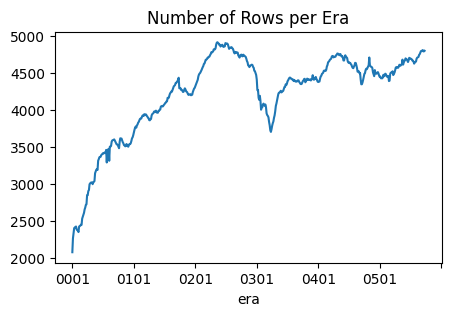

In [48]:
# Let's plot the number of rows per era
# This correspondss to the number stocks in Numerai's investable universe over time
training_data.groupby("era").size().plot(title="Number of Rows per Era", figsize=(5, 3));

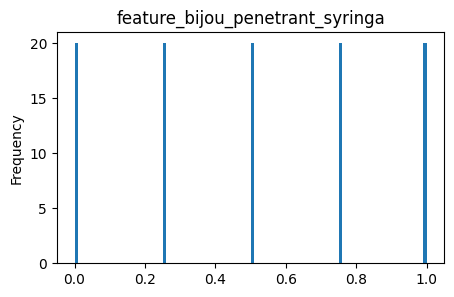

In [22]:
# Feature values are all between 0 and 1 and binned into 5 equal bins 
training_data[feature_cols[0]].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title=feature_cols[0]);

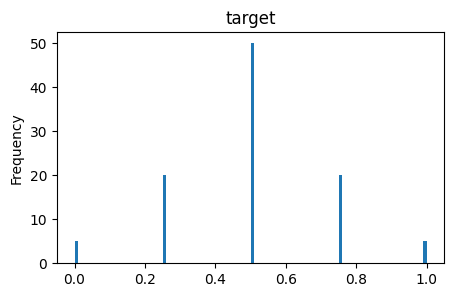

In [10]:
# The target value is also between 0 and 1 but binned into 5 unequal bins
training_data["target"].plot(kind="hist", bins=100, density=True, figsize=(5, 3), title="target");

## 2. Modelling
Our task is to train a machine learning model to predict the target.

In [92]:
# Let's train a simple model using LightGBM
# This will take about 2 minutes 🍵
from lightgbm import LGBMRegressor
params = {
   "n_estimators": 2000,
   "learning_rate": 0.01,
   "max_depth": 5,
   "num_leaves": 2 ** 5,
   "colsample_bytree": 0.1
}
model = LGBMRegressor(**params)
model.fit(
   training_data[feature_cols],
   training_data["target"]
);

In [64]:
# Let's download the validation dataset and make predictions against it to evaluate our model
# This will take about 2 minutes 🍵
napi.download_dataset("v4.1/validation.parquet")

2023-04-08 22:12:41,829 INFO numerapi.utils: target file already exists
2023-04-08 22:12:41,830 INFO numerapi.utils: starting download
v4.1/validation.parquet: 3.08GB [01:34, 32.7MB/s]                            


In [74]:
# Again we only load the "small" subset of the features to save time and memory
# This time, we will also load the "data_type" column so that we can filter against it
# In this example we will only need the rows where data_type == "validation"
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"])
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]


In [75]:
# The structure of the validation dataset is the same as the training dataset
# Notice the eras pick up where the training dataset eras left off
validation_data

,era,feature_bijou_penetrant_syringa,...,feature_unventilated_sollar_bason,target
id,,,,,
n000101811a8a843,0575,0.25,...,0.75,0.50
n001e1318d5072ac,0575,0.50,...,0.75,0.00
n002a9c5ab785cbb,0575,0.25,...,0.25,0.50
n002ccf6d0e8c5ad,0575,0.25,...,0.00,0.25
n0051ab821295c29,0575,1.00,...,1.00,0.50
...,...,...,...,...,...
nffd4dca666527aa,1052,0.50,...,0.75,0.50
nffdbcade5a291a7,1052,0.75,...,0.25,0.50
nfff85c23d664eed,1052,0.50,...,1.00,1.00


In [76]:
# Let's make predictions against the validation dataset
# This will take about 2 minutes 🍵
predictions = model.predict(validation_data[feature_cols])
predictions

array([0.48395846, 0.49499011, 0.50121331, ..., 0.48703664, 0.49981811,
       0.49380213])

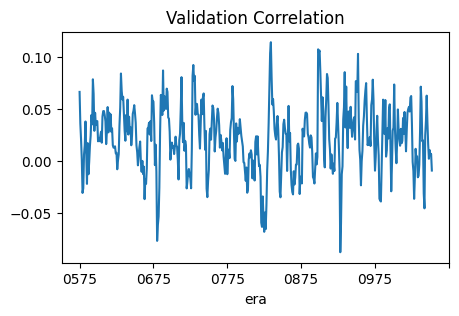

In [77]:
# How well did our model do? 
# Let's compute the per-era correlation between our predictions and the target
# Correlation to the target or CORR is the primary metric used to evaluate Numerai models
# As you can see our model has positive correlation with the target on some eras but negative correlation on others
validation_data["prediction"] = predictions
validation_data.groupby("era").apply(lambda x: x["prediction"].corr(x["target"])).plot(title="Validation Correlation", figsize=(5, 3));

In [78]:
# What is the average correlation across all eras?
# Predicting the stock is HARD, an average correlation of just 0.03 is considered a very good model
# Our model performance here is not great but it's good enough to get started
validation_data.groupby("era").apply(lambda x: x["prediction"].corr(x["target"])).mean()

0.021279439294380365

# 3. Submissions
Unlike a Kaggle competition where models are often evaluated based on their performance on a hold out test set, Numerai evaluates models based only on their <ins>live performance</ins> in the real stock market.

To compete in the tournament, your model must submit live predictions on live features released every day. Only the scores of these live predictions count towards your model's live performance.

Here is how you create a single live submission using the latest live features released today. 

In [103]:
# Download latest live features
napi.download_dataset("v4.1/live.parquet")

# Load live features
live_features = pd.read_parquet("v4.1/live.parquet", columns=feature_cols)

# Generate live predictions
live_predictions = model.predict(live_features[feature_cols])

# Format submission
submission = pd.Series(live_predictions, index=live_features.index).to_frame("prediction")
submission

2023-04-08 22:57:37,618 INFO numerapi.utils: target file already exists
2023-04-08 22:57:37,620 INFO numerapi.utils: download complete


,prediction
id,
n000ccedd86fc94f,0.508249
n00176ebf594813d,0.498361
n001cf85bd0f00c2,0.513214
n0021b1a1cd9b6a2,0.494165
n00265667860b9a4,0.493760
...,...
nffd201c03edde50,0.484038
nffe84ece843f7a5,0.495339
nffe973d2b240b11,0.497390


To automate your daily submission, you can simply <ins>pickle</ins> and <ins>upload your model pipeline</ins> to Numerai.

In [100]:
# Define your model pipeline as a function that takes a dataframe of features and returns a dataframe of predictions
# You can add any arbitrary code here but just know that you won't have access to the network or file system during runtime
# Also note that your model will be run in a sandboxed environment with limited resources and must complete within 60 minutes.
def predict(live_features):
    live_predictions = model.predict(live_features[feature_cols])
    submission = pd.Series(live_predictions, index=live_features.index)
    return submission.to_frame("prediction")

# Use the cloudpickle library to serialize your model pipeline and all its dependencies
import cloudpickle
p = cloudpickle.dumps(predict)
with open("example_model.pkl", "wb") as f:
    f.write(p)

In [105]:
# If running in Colab, download the model file
try:
  from google.colab import files
  files.download('example_model.pkl')
except:
  pass

Now login to your Numerai account upload the model pickle file at [numer.ai/models](numer.ai/models)!